# Application of calorimetry cuts on single-particle gun files
For track-cluster matched files, when cluster energy is summed for individual calorimenters
New files from the afterburner Nov-2021, using the calibration flag that could be set to “improve” the E/p 
(i.e., move it closer to 1)

last update Nov-8, 2021 (EOC)



## definitions

In [142]:
from IPython.display import display
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
import ROOT

Welcome to JupyROOT 6.24/04


In [3]:
calorimeter_names=["FHCAL", "FEMC", "DRCALO", "EEMC", "CEMC", "EHCAL", "HCALIN", "HCALOUT", "LFHCAL", "EEMCG", "BECAL"]
Ncalorimeters = len(calorimeter_names)

In [6]:
# Tyler (Oct-9, 2021):
# YR is a nice guide but has obviously changed somewhat with the current ECCE design.
# -1 < eta < +1 for BECAL
# -3 < eta < -2 for EEMC
# 2 < eta < 3 for FEMC (maybe slightly lower minimum...around 1.8?)

# Tyler (Nov-2, 2021):
# -3.8 < eta < -1.75 (EEMC)
# -1.75 < eta < 1.265 (BECAL)
# We can include eta down to -3.8 for the EEMC, but since we are applying a kinematic cut of eta > -3.5, this region is not so important.  Also, the boundary at eta = -1.75 should “split” the gap between the EEMC and BECAL.  We should expect to see bad performance around here as there is a gap in the calorimeter.


regions      = ['backward','center'      ,'forward' ]
region_labels= ['low-$x$' ,'medium-$x$'  ,'high-$x$']
region_EMCALs= ['EEMC'    ,'BECAL'       ,'FEMC'    ]
region_HCALs = ['EHCAL'   ,'HCAL IN+OUT' ,'FHCAL'   ]
min_lims     = [-3.8      ,-1.75         ,1.75      ]
max_lims     = [-1.75     ,1.265         ,3.8       ]
max_lims

[-1.75, 1.265, 3.8]

In [7]:
e_color = 'k';
pi_color='royalblue';

eta_limits = dict()
for region,i in zip(regions,range(3)):
    eta_limits[region + ' min'] = min_lims[i]
    eta_limits[region + ' max'] = max_lims[i]    
eta_limits

{'backward min': -3.8,
 'backward max': -1.75,
 'center min': -1.75,
 'center max': 1.265,
 'forward min': 1.75,
 'forward max': 3.8}

## load data

In [8]:
e_rootfile  = ROOT.TFile("/Users/erezcohen/Desktop/data/EIC/ECCE/ElectronPionPID/electron_track_cluster_match_pass3.root")
e_ttree     = e_rootfile.Get("T")
e_entries   = e_ttree.GetEntriesFast()
print(e_entries,'electron events')

pi_rootfile = ROOT.TFile("/Users/erezcohen/Desktop/data/EIC/ECCE/ElectronPionPID/pion_track_cluster_match_pass3.root")
pi_ttree    = pi_rootfile.Get("T")
pi_entries  = pi_ttree.GetEntriesFast()
print(pi_entries,'pion events')

4581566 electron events
4639526 pion events


In [9]:
Pe  = np.array(e_ttree.AsMatrix(columns=["p_track"]))
Ppi = np.array(pi_ttree.AsMatrix(columns=["p_track"]))

/usr/local/Cellar/root/6.24.04_1/lib/root/ROOT/pythonization/_ttree.py:191: FutureWarning: TTree.AsMatrix is deprecated since v6.24 and will be removed in v6.26. Please use instead RDataFrame.AsNumpy.
  warnings.warn("TTree.AsMatrix is deprecated since v6.24 and will be removed in v6.26. Please use instead RDataFrame.AsNumpy.", FutureWarning)


In [10]:
eta_e  = np.array(e_ttree.AsMatrix(columns=["eta_track"]))
eta_pi = np.array(pi_ttree.AsMatrix(columns=["eta_track"]))

In [11]:
EClusterTot_e = dict()
for calorimeter_name in calorimeter_names:
    EClusterTot_e[calorimeter_name] = []

for i in range(e_entries): 
    e_ttree.GetEntry(i)
    for calorimeter_name,calorimeter_idx in zip(calorimeter_names,range(Ncalorimeters)):
#        EClusterTot_e[calorimeter_name].append(e_ttree.E_clusters[calorimeter_idx])    
        EClusterTot_e[calorimeter_name].append(e_ttree.E_clusters_match[calorimeter_idx])            
        

In [12]:
for calorimeter_name in calorimeter_names:
    EClusterTot_e[calorimeter_name] = np.array(EClusterTot_e[calorimeter_name])

In [13]:
EClusterTot_pi = dict()
for calorimeter_name in calorimeter_names:
    EClusterTot_pi[calorimeter_name] = []

for i in range(pi_entries): 
    pi_ttree.GetEntry(i)
    for calorimeter_name,calorimeter_idx in zip(calorimeter_names,range(Ncalorimeters)):
        # EClusterTot_pi[calorimeter_name].append(pi_ttree.E_clusters[calorimeter_idx])
        EClusterTot_pi[calorimeter_name].append(pi_ttree.E_clusters_match[calorimeter_idx])    

In [14]:
for calorimeter_name in calorimeter_names:
    EClusterTot_pi[calorimeter_name] = np.array(EClusterTot_pi[calorimeter_name])

## auxiliary functions

In [132]:
def get_region_from_eta_lims(eta_min,eta_max):
    if ((eta_limits['backward min']<=eta_min) & (eta_max<=eta_limits['backward max'])):   region='backward'; region_EMCAL='EEMC'
    elif ((eta_limits['center min']<=eta_min) & (eta_max<=eta_limits['center max'])):     region='center'  ; region_EMCAL='BECAL'  
    elif ((eta_limits['forward min']<=eta_min) & (eta_max<=eta_limits['forward max'])):   region='forward' ; region_EMCAL='FEMC'  
    else: region='unknown region'
    return region,region_EMCAL

def get_region_label_from_region(region):
    if region=='backward':  return region_labels[0]
    elif region=='center':  return region_labels[1]
    elif region=='forward': return region_labels[2]
    return ''
    
def get_regionCuts_from_region(region):
    if region=='backward':  region_EMCAL,EMCAL_min_cut,region_HCAL,HCAL_max_cut = 'EEMC',EMCAL_min_cuts[0],'EHCAL',HCAL_max_cuts[0]
    elif region=='center':  region_EMCAL,EMCAL_min_cut,region_HCAL,HCAL_max_cut = 'BECAL',EMCAL_min_cuts[1],'HCAL IN+OUT', HCAL_max_cuts[1]
    elif region=='forward': region_EMCAL,EMCAL_min_cut,region_HCAL,HCAL_max_cut = 'FEMC',EMCAL_min_cuts[2],'FHCAL',HCAL_max_cuts[2]

    return region_EMCAL,EMCAL_min_cut,region_HCAL,HCAL_max_cut 

In [161]:
def plot_step_hist( x_arr, bins=np.linspace(0,1,10), label="", color='k', density=False):
    h,edges = np.histogram( x_arr, bins=bins )
    h_err = np.sqrt(h)

    if density==True:
        h_err = h_err/np.sum(h)
        # h     = h / np.sum(h)
        h,edges = np.histogram( x_arr, bins=bins, density=True )

    x     = (edges[1:] + edges[:-1])/2
    x_err = (edges[1:] - edges[:-1])/2
    plt.step ( x, h, color=color, where='mid', label=None ) 
    plt.errorbar ( x=x, xerr=x_err, y=h, yerr=h_err, color=color, marker='o', linestyle='None',label=label, capsize=2, capthick=2 )
    return x,h,x_err,h_err

In [16]:
def compute_fraction_in_cut( x_e, x_e_in_cut, x_pi, x_pi_in_cut):
    N_e        = float(len(x_e))
    N_e_in_cut = float(len(x_e_in_cut))
    f_e_in_cut = N_e_in_cut / N_e
    f_e_in_cut_err = f_e_in_cut*sqrt(1./np.max([1,N_e_in_cut]) +1./np.max([1,N_e]))

    N_pi        = float(len(x_pi))
    N_pi_in_cut = float(len(x_pi_in_cut))
    f_pi_in_cut = N_pi_in_cut / np.max([1,N_pi])
    f_pi_in_cut_err = f_pi_in_cut*sqrt(1./np.max([1,N_pi_in_cut]) +1./np.max([1,N_pi]))

    return f_e_in_cut, f_pi_in_cut, f_e_in_cut_err, f_pi_in_cut_err

In [17]:
def compute_survival_rate( x_e, x_pi, x_cut, filter_direction='above'):
    # f_e_in_cut, f_pi_in_cut, f_e_in_cut_err, f_pi_in_cut_err = 
    # compute_survival_rate( x_e, x_p, x_cut, filter_direction='above')
    if filter_direction=='above':        
        x_e_in_cut  = x_e [x_e > x_cut]
        x_pi_in_cut = x_pi[x_pi > x_cut]

    elif filter_direction=='below':        
        x_e_in_cut  = x_e [x_cut > x_e]
        x_pi_in_cut = x_pi[x_cut > x_pi]
    
    f_e_in_cut, f_pi_in_cut, f_e_in_cut_err, f_pi_in_cut_err = compute_fraction_in_cut( x_e, x_e_in_cut, x_pi, x_pi_in_cut)
    return f_e_in_cut, f_pi_in_cut, f_e_in_cut_err, f_pi_in_cut_err

In [176]:
def print_number_of_events(df_e,df_pi, Ne_0, Npi_0,label='',do_print=False):
    # Ne,Npi,fe,fe_err,fpi,fpi_err = print_number_of_events(df_e,df_pi, Ne_0, Npi_0,label='')
    Ne  = float(len(df_e))
    Npi = float(len(df_pi))
    Ne_0, Npi_0 = float(Ne_0), float(Npi_0)
    fe      = Ne/Ne_0
    fe_err  = fe*np.sqrt(1./np.max([1,Ne]) + 1./Ne_0)
    fpi     = Npi/Npi_0
    fpi_err = fpi*np.sqrt(1./np.max([1,Npi]) + 1./Npi_0)
    
    if do_print: print(label + ' electrons survival: %.2f(%.0f), pions survival: %.2f(%.0f)'          
                       %( 100.*fe, 10000.*fe_err,100.*fpi,10000.*fpi_err), '%')
    return Ne,Npi,fe,fe_err,fpi,fpi_err

In [19]:
def plot_calorimetry_response(df_e, df_pi,
                              caloname = 'BECAL',
                              P_bins = np.linspace(0,25,100),                             
                              ECALtot_bins = np.linspace(0.5,15,100),
                              EoverP_bins = np.linspace(0.1,1.2,100),
                              EoverP_cut=1,
                              fdebug=0):
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(2,2,1)
    plot_step_hist( df_e['p'],  bins=P_bins, label="$e$", color=e_color)
    plot_step_hist( df_pi['p'], bins=P_bins, label="$\pi$", color=pi_color)
    set_axes(ax,'$p$ [GeV/c]','counts',title='Reconstructed momentum',do_add_grid=True,do_add_legend=True)
    ax.set_yscale('log')


    ax = fig.add_subplot(2,2,2)
    plot_step_hist( df_e[ caloname+' E'], bins=ECALtot_bins, label="$e$", color=e_color)
    plot_step_hist( df_pi[caloname+' E'], bins=ECALtot_bins, label="$\pi$", color=pi_color)
    set_axes(ax,'$\sum E_{cluster}$ [GeV]','',title='Sum over cluster energy in '+caloname,do_add_grid=True,do_add_legend=True)
    ax.set_yscale('log')


    ax = fig.add_subplot(2,2,(3,4))
    x,h_e,x_err,h_err_e   = plot_step_hist( df_e [caloname+' E/p'] , bins=EoverP_bins, label="$e$", color=e_color  , density=True)
    x,h_pi,x_err,h_err_pi = plot_step_hist( df_pi[caloname+' E/p'], bins=EoverP_bins, label="$\pi$", color=pi_color, density=True)
    ax.plot( [EoverP_cut,EoverP_cut],ax.get_ylim(),'-r' )
    set_axes(ax,'$\sum E_{cluster}/p$','',title=caloname+' calorimetry response',do_add_grid=True,
             do_add_legend=False)

    plt.tight_layout()
    
    if fdebug:
        print('h_e[0:10]:',h_e[0:10])
        print('herr_e[0:10]:',h_err_e[0:10])

## compute $E/p$ and define dataframes

In [20]:
for calorimeter_name in calorimeter_names:
    print(calorimeter_name)
    EClusterTot_pi[calorimeter_name + ' E/p'] = EClusterTot_pi[calorimeter_name]/np.squeeze(Ppi)
    EClusterTot_e[calorimeter_name + ' E/p']  = EClusterTot_e[calorimeter_name] /np.squeeze(Pe)

FHCAL
FEMC
DRCALO
EEMC
CEMC
EHCAL
HCALIN
HCALOUT
LFHCAL
EEMCG
BECAL


In [21]:
pions = pd.DataFrame({'p':np.squeeze(Ppi),
                      'eta':np.squeeze(eta_pi),
                      'BECAL E':EClusterTot_pi['BECAL']    ,'BECAL E/p':EClusterTot_pi['BECAL E/p'],
                      'EEMC E':EClusterTot_pi['EEMC']      ,'EEMC E/p':EClusterTot_pi['EEMC E/p'],
                      'FEMC E':EClusterTot_pi['FEMC']      ,'FEMC E/p':EClusterTot_pi['FEMC E/p'],
                      'HCALIN E':EClusterTot_pi['HCALIN']  ,'HCALIN E/p':EClusterTot_pi['HCALIN E/p'],
                      'HCALOUT E':EClusterTot_pi['HCALOUT'],'HCALOUT E/p':EClusterTot_pi['HCALOUT E/p'],
                      'EHCAL E':EClusterTot_pi['EHCAL']    ,'EHCAL E/p':EClusterTot_pi['EHCAL E/p'],
                      'FHCAL E':EClusterTot_pi['FHCAL']    ,'FHCAL E/p':EClusterTot_pi['FHCAL E/p'],
                     })

electrons = pd.DataFrame({'p':np.squeeze(Pe),
                          'eta':np.squeeze(eta_e),
                          'BECAL E':EClusterTot_e['BECAL']    ,'BECAL E/p':EClusterTot_e['BECAL E/p'],
                          'EEMC E':EClusterTot_e['EEMC']      ,'EEMC E/p':EClusterTot_e['EEMC E/p'],
                          'FEMC E':EClusterTot_e['FEMC']      ,'FEMC E/p':EClusterTot_e['FEMC E/p'],
                          'HCALIN E':EClusterTot_e['HCALIN']  ,'HCALIN E/p':EClusterTot_e['HCALIN E/p'],
                          'HCALOUT E':EClusterTot_e['HCALOUT'],'HCALOUT E/p':EClusterTot_e['HCALOUT E/p'],                         
                          'EHCAL E':EClusterTot_e['EHCAL']    ,'EHCAL E/p':EClusterTot_e['EHCAL E/p'],
                          'FHCAL E':EClusterTot_e['FHCAL']    ,'FHCAL E/p':EClusterTot_e['FHCAL E/p'],
                     })

In [22]:
pions['HCAL IN+OUT E/p']     = pions['HCALIN E/p'] + pions['HCALOUT E/p']
electrons['HCAL IN+OUT E/p'] = electrons['HCALIN E/p'] + electrons['HCALOUT E/p']

## Classification of the events to regions

In [23]:
pi_regions, el_regions = dict(), dict()
for region in regions:
    pi_regions[region] = pions[ (eta_limits[region+' min'] < pions['eta']) 
                                &
                                (pions['eta'] < eta_limits[region+' max'] )]
    el_regions[region] = electrons[ (eta_limits[region+' min'] < electrons['eta']) 
                                &
                                (electrons['eta'] < eta_limits[region+' max'] )]

## Event selection cuts

(1) First, we subdivide into bins of outgoing momentum and $\eta$.

(2) In each bin, we fit the distribution of electron $E/p$ to a Gaussian

(3) The mean ($\mu_{E/p}$) and standard deviations ($\sigma_{E/p}$) of the best fit results are used to define the $\pi$ rejection criterion in this bin: we retain only $$ E/p > \mu_{E/p} - 1.6 \cdot \sigma_{E/p} $$

(4) Then, the pion rejection and electron selection efficiencies are defined for this bin as the fraction of events reatined after applying this criterion


### binning

In [123]:
p_bins   = np.linspace(0,20,21) # 1 GeV/c bins
p_centers = (p_bins[1:]+p_bins[:-1])/2
p_widths  = (p_bins[1:]-p_bins[:-1])/2
p_mins    = p_centers-p_widths
p_maxs    = p_centers+p_widths
p_mins,p_maxs

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20.]))

In [124]:
eta_lim_EEMC_dw = eta_limits['backward min']
eta_lim_EEMC_up = eta_limits['backward max']

eta_lim_BECAL_dw = eta_limits['center min']
eta_lim_BECAL_up = eta_limits['center max']

eta_lim_FEMC_dw = eta_limits['forward min']
eta_lim_FEMC_up = eta_limits['forward max']

eta_mins    = np.concatenate([np.linspace(eta_lim_EEMC_dw,eta_lim_EEMC_up-(eta_lim_EEMC_up-(eta_lim_EEMC_dw))/4,4) , 
                              np.linspace(eta_lim_BECAL_dw,eta_lim_BECAL_up-(eta_lim_BECAL_up-(eta_lim_BECAL_dw))/4,4) , 
                              np.linspace(eta_lim_FEMC_dw,eta_lim_FEMC_up-(eta_lim_FEMC_up-(eta_lim_FEMC_dw))/4,4) ])
eta_maxs    = np.concatenate([np.linspace(eta_lim_EEMC_dw+(eta_lim_EEMC_up-(eta_lim_EEMC_dw))/4,eta_lim_EEMC_up,4) , 
                              np.linspace(eta_lim_BECAL_dw+(eta_lim_BECAL_up-(eta_lim_BECAL_dw))/4,eta_lim_BECAL_up,4) , 
                              np.linspace(eta_lim_FEMC_dw+(eta_lim_FEMC_up-(eta_lim_FEMC_dw))/4,eta_lim_FEMC_up,4) ])
eta_centers = (eta_maxs+eta_mins)/2
eta_widths  = (eta_maxs-eta_mins)/2
eta_mins,eta_maxs

(array([-3.8    , -3.2875 , -2.775  , -2.2625 , -1.75   , -0.99625,
        -0.2425 ,  0.51125,  1.75   ,  2.2625 ,  2.775  ,  3.2875 ]),
 array([-3.2875 , -2.775  , -2.2625 , -1.75   , -0.99625, -0.2425 ,
         0.51125,  1.265  ,  2.2625 ,  2.775  ,  3.2875 ,  3.8    ]))

### fit and plot

In [224]:
EoverP_bins  = np.linspace(0.01,1.6,50)
selection_df = pd.DataFrame(columns={'$\eta_{min}$','$\eta_{max}$',
                                  'region','EMCAL',
                                  '$p_{min}$','$p_{max}$',
                                  '$E/p_{min}^{EMCAL}$',
                                  '$\epsilon_e$'    ,'$\Delta \epsilon_e$',
                                  '$\epsilon_\pi$'  ,'$\Delta \epsilon_\pi$',
                                  '$\\xi_\pi$'       ,'$\Delta \\xi_\pi$'})

In [225]:
fdebug  = 1
do_plot = False
figsize = (20,16) # each figure includes 20 momentum bins, so we subdivide it into 4 rows x 5 columns
fontsize= 18

bin_idx = 0;
for eta_idx in range(len(eta_mins)): #{[0]:#
    eta_min,eta_max = eta_mins[eta_idx],eta_maxs[eta_idx]    
    if fdebug>2: print('eta_min,eta_max:',eta_min,eta_max)
    region,region_EMCAL = get_region_from_eta_lims(eta_min,eta_max)
    
    fig = plt.figure(figsize=figsize)
    
    for p_idx in range(len(p_mins)):#{ [0]:#
        p_min,p_max = p_mins[p_idx],p_maxs[p_idx]
        if fdebug>2: print('p_min,p_max:',p_min,p_max)
        
        # define data sets
        df_el, df_pi = el_regions[region], pi_regions[region]
        
        df_el = df_el[ (eta_min<df_el['eta']) & (df_el['eta']<eta_max)]
        df_el = df_el[ (p_min<df_el['p']) & (df_el['p']<p_max)]

        df_pi = df_pi[ (eta_min<df_pi['eta']) & (df_pi['eta']<eta_max)]
        df_pi = df_pi[ (p_min<df_pi['p']) & (df_pi['p']<p_max)]
        
        # fit electron E/p distribution to Gaussian
        x=df_el[region_EMCAL+' E/p']
        x = x[(0.5<x) & (x<1.2)]
        mu,sigma = fit_array_to_Gaussian(x=x,do_plot=False)

        # define cut
        EMCAL_min_cut = mu - 1.6 * sigma;

        # apply cut
        df_el_in_cut  = df_el[df_el[region_EMCAL+' E/p']>EMCAL_min_cut]
        df_pi_in_cut  = df_pi[df_pi[region_EMCAL+' E/p']>EMCAL_min_cut]
        Ne,Npi,fe,fe_err,fpi,fpi_err = print_number_of_events( df_el_in_cut, df_pi_in_cut, 
                                       len(df_el), len(df_pi), label='Requiring E/p in %s>%.2f'%(region,EMCAL_min_cut));

        # record data in data-frame
        selection_df = selection_df.append(pd.DataFrame({'$\eta_{min}$':eta_min,'$\eta_{max}$':eta_max,
                                  'region':region,'EMCAL':region_EMCAL,
                                  '$p_{min}$':p_min,'$p_{max}$':p_max,
                                  '$E/p_{min}^{EMCAL}$':EMCAL_min_cut,
                                  '$\epsilon_e$':fe    ,'$\Delta \epsilon_e$':fe_err,
                                  '$\epsilon_\pi$':fpi  ,'$\Delta \epsilon_\pi$':fpi_err,
                                  '$\\xi_\pi$':1./fpi ,'$\Delta \\xi_\pi$':fpi_err},index=[bin_idx]))
        
        # increment index
        bin_idx = bin_idx+1;

        
        if do_plot:#{
            # plot
            ax = fig.add_subplot(4,5,p_idx+1)
            x,h_e,x_err,h_err=plot_step_hist( df_el[region_EMCAL+' E/p'], bins=EoverP_bins, label="$e$",   
                       color=e_color,  density=True)
            plot_step_hist( df_pi[region_EMCAL+' E/p'], bins=EoverP_bins, label="$\pi$", 
                       color=pi_color, density=True)    

            # plot Gaussian
            x_fit = np.linspace(np.min(x),np.max(x),100)
            y_fit = norm.pdf( x_fit, mu, sigma )
            plt.plot(x_fit, y_fit, '--', color='salmon', linewidth=2,label=None)


            # plot cut
            ymax=1.2*np.max(h_e);
            ax.plot([EMCAL_min_cut,EMCAL_min_cut],[0,ymax],'-r')
            ax.fill_between([EMCAL_min_cut,np.max(bins)],[0,0],[ymax,ymax],color='red',alpha=0.1)
            # ax.text(EMCAL_min_cut-0.4,0.8*np.max(ylim),'$E/p > %.2f$'%EMCAL_min_cut,color='r',fontsize=18)

            xlabel = '$E/p$' if p_idx+1>15 else ''
            remove_ticks_x = False if p_idx+1>15 else True
            ylabel = ''
            title  = ('$%.2f<\eta<%.2f$'%(eta_min,eta_max)
                      + '\n' 
                      + '%.1f < $p$ < %.1f GeV/c'%(p_min,p_max) 
                      + '\n' 
                      + '$\epsilon_e = %.2f(%.0f), \epsilon_\pi = %.2f(%.0f)$'%(fe,fe_err*100,fpi,fpi_err*100))
            set_axes(ax,xlabel,ylabel,title=title,do_add_grid=True,
                     do_add_legend=False,fontsize=fontsize,
                     remove_ticks_x=remove_ticks_x,
                     remove_ticks_y=True,
                     xlim=[0,np.max(bins)],ylim=[0,ymax])
            #}

    #}
    
    if do_plot: plt.tight_layout()
#}

print('done')



done


<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

<Figure size 1440x1152 with 0 Axes>

In [226]:
pd.set_option("max_colwidth", 40)
pd.set_option("precision", 4)
display(selection_df[['$\eta_{min}$','$\eta_{max}$','EMCAL',
                                  '$p_{min}$','$p_{max}$',
                                  '$\epsilon_e$'    ,'$\Delta \epsilon_e$',
                                  '$\epsilon_\pi$'  ,'$\Delta \epsilon_\pi$',
                                  '$\\xi_\pi$'       ,'$\Delta \\xi_\pi$']])

,$\eta_{min}$,$\eta_{max}$,EMCAL,$p_{min}$,$p_{max}$,$\epsilon_e$,$\Delta \epsilon_e$,$\epsilon_\pi$,$\Delta \epsilon_\pi$,$\xi_\pi$,$\Delta \xi_\pi$
0,-3.8000,-3.2875,EEMC,0.0,1.0,0.9715,0.0156,0.4298,0.0105,2.3268,0.0105
1,-3.8000,-3.2875,EEMC,1.0,2.0,0.9764,0.0098,0.4130,0.0056,2.4212,0.0056
2,-3.8000,-3.2875,EEMC,2.0,3.0,0.9646,0.0117,0.3685,0.0062,2.7140,0.0062
3,-3.8000,-3.2875,EEMC,3.0,4.0,0.9508,0.0149,0.3260,0.0073,3.0673,0.0073
4,-3.8000,-3.2875,EEMC,4.0,5.0,0.9328,0.0178,0.2842,0.0081,3.5191,0.0081
...,...,...,...,...,...,...,...,...,...,...,...
235,3.2875,3.8000,FEMC,15.0,16.0,0.8458,0.0578,0.0243,0.0074,41.0909,0.0074
236,3.2875,3.8000,FEMC,16.0,17.0,0.8525,0.0657,0.0249,0.0080,40.1000,0.0080
237,3.2875,3.8000,FEMC,17.0,18.0,0.8261,0.0661,0.0351,0.0095,28.5000,0.0095
238,3.2875,3.8000,FEMC,18.0,19.0,0.8296,0.0750,0.0206,0.0079,48.4286,0.0079


## Add initial $\pi/e$ ratio from Xiaochao Z.
Nov-3, 2021

In [248]:
Xsec_data_path ='/Users/erezcohen/Desktop/data/EIC/ECCE/ElectronPionPID/djangoh.4.6.16/';
bg_djangoh = pd.read_csv(Xsec_data_path + 'background_djangoh_etaE_ep_18_275.csv',
                         names=['Eprime_min','Eprime_max','eta_min','eta_max','e-','e+','pi0','pi+','pi-','photon','proton','neutron'])
bg_djangoh

,Eprime_min,Eprime_max,eta_min,eta_max,e-,e+,pi0,pi+,pi-,photon,proton,neutron
0,0.30,0.45,-1.2,-0.9,2,0,609,366,389,156580,0,0
1,0.30,0.45,-0.3,0.0,1,2,247,176,167,19276,0,0
2,0.45,0.60,-3.9,-3.6,4,0,730,518,501,8381,0,0
3,0.45,0.60,-3.6,-3.3,2,2,909,633,571,6614,0,0
4,0.45,0.60,-3.3,-3.0,8,1,1130,827,746,5262,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
353,4.35,4.50,-1.5,-1.2,123,1,93,95,106,24 1,6 1,8
354,4.35,4.50,-1.2,-0.9,85,0,86,71,63,16 1,5 1,5
355,4.35,4.50,-0.9,-0.6,94,1,59,66,64,18 1,6,7
356,4.35,4.50,-0.6,-0.3,66,0,39,47,51,10 1,3,8


In [256]:
bg_djangoh['Eprime'] = (bg_djangoh['Eprime_max']+bg_djangoh['Eprime_min'])/2
bg_djangoh['eta']    = (bg_djangoh['eta_max']+bg_djangoh['eta_min'])/2
bg_djangoh['pi/e']   = np.array(bg_djangoh['pi-'])/np.array(bg_djangoh['e-'])

TypeError: unsupported operand type(s) for /: 'int' and 'str'

In [257]:
np.array(bg_djangoh['e-'])

array(['2', '1', '4', '2', '8', '5', '10', '10', '17', '17', '195', '728',
       '1184', '1425', '1590', '1692', '1632', '1567', '1506', '1445',
       '1322', '1241', '1199', '1103', '951', '969', '761', '767', '612',
       '441', '400', '343', '255', '246', '193', '151', '105', '117',
       '113', '94', '85', '66', '96', '111', '121', '106', '122',
       '1086       1', '2', '2', '3', '2', '2', '8', '5', '177', '985',
       '1498', '1732', '1391', '1032', '824', '678', '541', '498', '345',
       '307', '266', '181', '153', '137', '140', '104', '97', '100', '84',
       '116', '106', '97', '87', '63', '88', '59', '56', '50', '40', '38',
       '39', '31', '24', '28', '26', '32', '31', '36', '60', '2', '2',
       '2', '2', '1', '5', '2', '3', '3', '3', '21', '790', '1486',
       '1197', '606', '479', '424', '321', '268', '229', '214', '158',
       '118', '89', '83', '73', '63', '62', '35', '36', '33', '44', '43',
       '51', '38', '37', '31', '45', '51', '32', '46', '43', '22

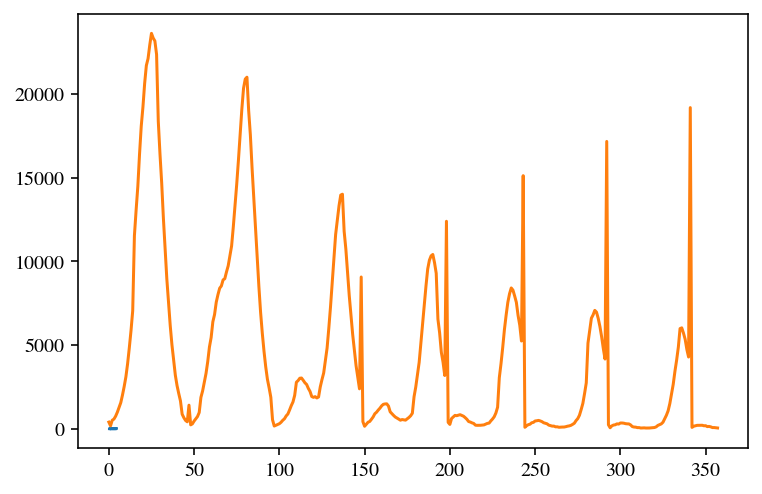

In [246]:
# e_matrix = plt.hist2d( bg_djangoh['Eprime'], bg_djangoh['eta'] )
x = np.array(bg_djangoh['Eprime'])
y = np.array(bg_djangoh['eta'])
z = np.array(bg_djangoh['pi-'])
# z_min,z_max = np.min(z),np.max(z)
fig=plt.figure();
ax=fig.add_subplot(111)
ax.plot(x, y, z)#, cmap='RdBu', vmin=z_min, vmax=z_max)


# arxiv

In [46]:
EMCAL_min_cuts = [0.75, 0.77, 0.80]
HCAL_max_cuts  = [0.02, 0.1, 0.01]

### initial number of electrons and pions

In [47]:
Ne,Npi = dict(),dict()
for region in regions:    
    Ne[region], Npi[region] = print_number_of_events( el_regions[region],pi_regions[region], 1, 1,label=region)

print ('Ne:',Ne)
print ('Npi:',Npi)

backward electrons survival: 112196700.00(11219675000), pions survival: 111559000.00(11155905000) %
center electrons survival: 205068200.00(20506825000), pions survival: 209910100.00(20991015000) %
forward electrons survival: 109581600.00(10958165000), pions survival: 109724600.00(10972465000) %
Ne: {'backward': 1121967.0, 'center': 2050682.0, 'forward': 1095816.0}
Npi: {'backward': 1115590.0, 'center': 2099101.0, 'forward': 1097246.0}


### Require that there is a track-cluster matching
By requiring that $E/p$ in the EM calorimeter is greater than 0

In [48]:
for (region,region_EMCAL,EMCAL_min_cut) in zip(regions,region_EMCALs,EMCAL_min_cuts):

    el_regions[region+' cluster-track matched']  = el_regions[region][el_regions[region][region_EMCAL+' E/p']>0]
    pi_regions[region+' cluster-track matched']  = pi_regions[region][pi_regions[region][region_EMCAL+' E/p']>0]

    # Ne[region], Npi[region] = print_number_of_events( el_regions[region+' cluster-track matched'],pi_regions[region+' cluster-track matched'], 
    #                        Ne[region], Npi[region],label='Requiring E/p in %s>0'%(region));
    print_number_of_events( el_regions[region+' cluster-track matched'],pi_regions[region+' cluster-track matched'], 
                           Ne[region], Npi[region],label='Requiring E/p in %s>0'%(region));
    

Requiring E/p in backward>0 electrons survival: 92.78(13), pions survival: 69.44(10) %
Requiring E/p in center>0 electrons survival: 85.04(9), pions survival: 74.37(8) %
Requiring E/p in forward>0 electrons survival: 95.10(13), pions survival: 59.63(9) %


### Require that $E/p$ in the EM calorimeter is greater than $E/p_{min}$ 

In [49]:
for (region,region_EMCAL,EMCAL_min_cut) in zip(regions,region_EMCALs,EMCAL_min_cuts):

    # el_regions[region+' EMCAL cut']  = el_regions[region+' cluster-track matched'][el_regions[region+' cluster-track matched'][region_EMCAL+' E/p']>EMCAL_min_cut]
    # pi_regions[region+' EMCAL cut']  = pi_regions[region+' cluster-track matched'][pi_regions[region+' cluster-track matched'][region_EMCAL+' E/p']>EMCAL_min_cut]
    el_regions[region+' EMCAL cut']  = el_regions[region][el_regions[region][region_EMCAL+' E/p']>EMCAL_min_cut]
    pi_regions[region+' EMCAL cut']  = pi_regions[region][pi_regions[region][region_EMCAL+' E/p']>EMCAL_min_cut]


    print_number_of_events( el_regions[region+' EMCAL cut'],pi_regions[region+' EMCAL cut'], 
                           Ne[region], Npi[region],label='Requiring E/p in %s>%.2f'%(region,EMCAL_min_cut));
    

Requiring E/p in backward>0.75 electrons survival: 88.23(12), pions survival: 3.57(2) %
Requiring E/p in center>0.77 electrons survival: 81.40(8), pions survival: 2.58(1) %
Requiring E/p in forward>0.80 electrons survival: 93.58(13), pions survival: 5.81(2) %


### Require that $E/p$ in the hadronic calorimeter is smaller than $E/p_{max}$ 

In [50]:
for (region,region_HCAL,HCAL_max_cut) in zip(regions,region_HCALs,HCAL_max_cuts):

    el_regions[region+' HCAL cut']  = el_regions[region+' EMCAL cut'][el_regions[region+' EMCAL cut'][region_HCAL+' E/p']<HCAL_max_cut]
    pi_regions[region+' HCAL cut']  = pi_regions[region+' EMCAL cut'][pi_regions[region+' EMCAL cut'][region_HCAL+' E/p']<HCAL_max_cut]

    print_number_of_events( el_regions[region+' HCAL cut'],pi_regions[region+' HCAL cut'], 
                           Ne[region], Npi[region],label='Requiring E/p in %s<%.2f'%(region,HCAL_max_cut));
    

Requiring E/p in backward<0.02 electrons survival: 88.16(12), pions survival: 3.53(2) %
Requiring E/p in center<0.10 electrons survival: 81.14(8), pions survival: 2.57(1) %
Requiring E/p in forward<0.01 electrons survival: 93.58(13), pions survival: 5.81(2) %


### EM calorimetry response in the different regions

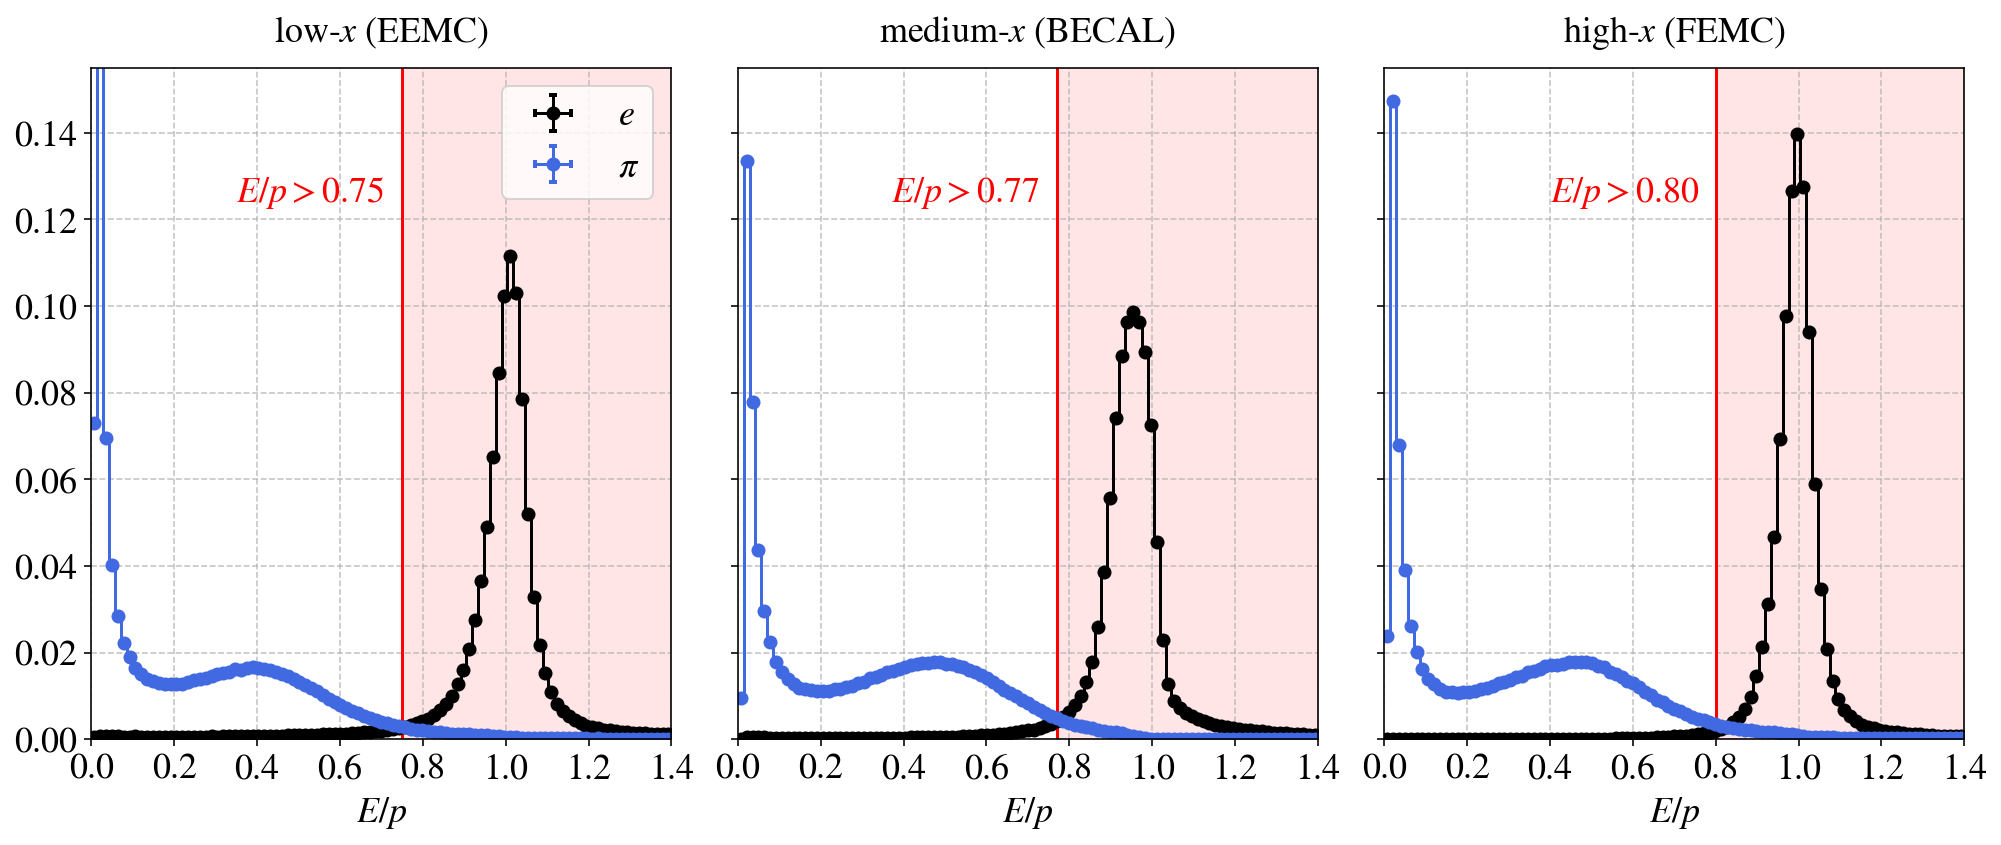

In [51]:
fig  = plt.figure(figsize=(14,6))
bins = np.linspace(0.0001,1.4,100)
ylim = (0,0.155)

for (region,i,region_label,
     region_EMCAL,EMCAL_min_cut) in zip(regions,range(3),region_labels,region_EMCALs,EMCAL_min_cuts):
    
    ax = fig.add_subplot(1,3,i+1)
    df_el, df_pi = el_regions[region], pi_regions[region]
    
    plot_step_hist( df_el[region_EMCAL+' E/p'], bins=bins, label="$e$",   
                   color=e_color,  density=True)
    plot_step_hist( df_pi[region_EMCAL+' E/p'], bins=bins, label="$\pi$", 
                   color=pi_color, density=True)    
    
    # plot cut
    ax.plot([EMCAL_min_cut,EMCAL_min_cut],ylim,'-r')
    ax.fill_between([EMCAL_min_cut,np.max(bins)],[0,0],[np.max(ylim),np.max(ylim)],color='red',alpha=0.1)
    ax.text(EMCAL_min_cut-0.4,0.8*np.max(ylim),'$E/p > %.2f$'%EMCAL_min_cut,color='r',fontsize=18)

    
    set_axes(ax,'$E/p$','',title=region_label+' ('+region_EMCAL+')',remove_ticks_y=True if i>0 else False,
             do_add_legend=True if i==0 else False,do_add_grid=True,fontsize=18,
             ylim=ylim, xlim=(0,np.max(bins)))
    
plt.tight_layout()

#### check if there is a difference as a function of kinematics

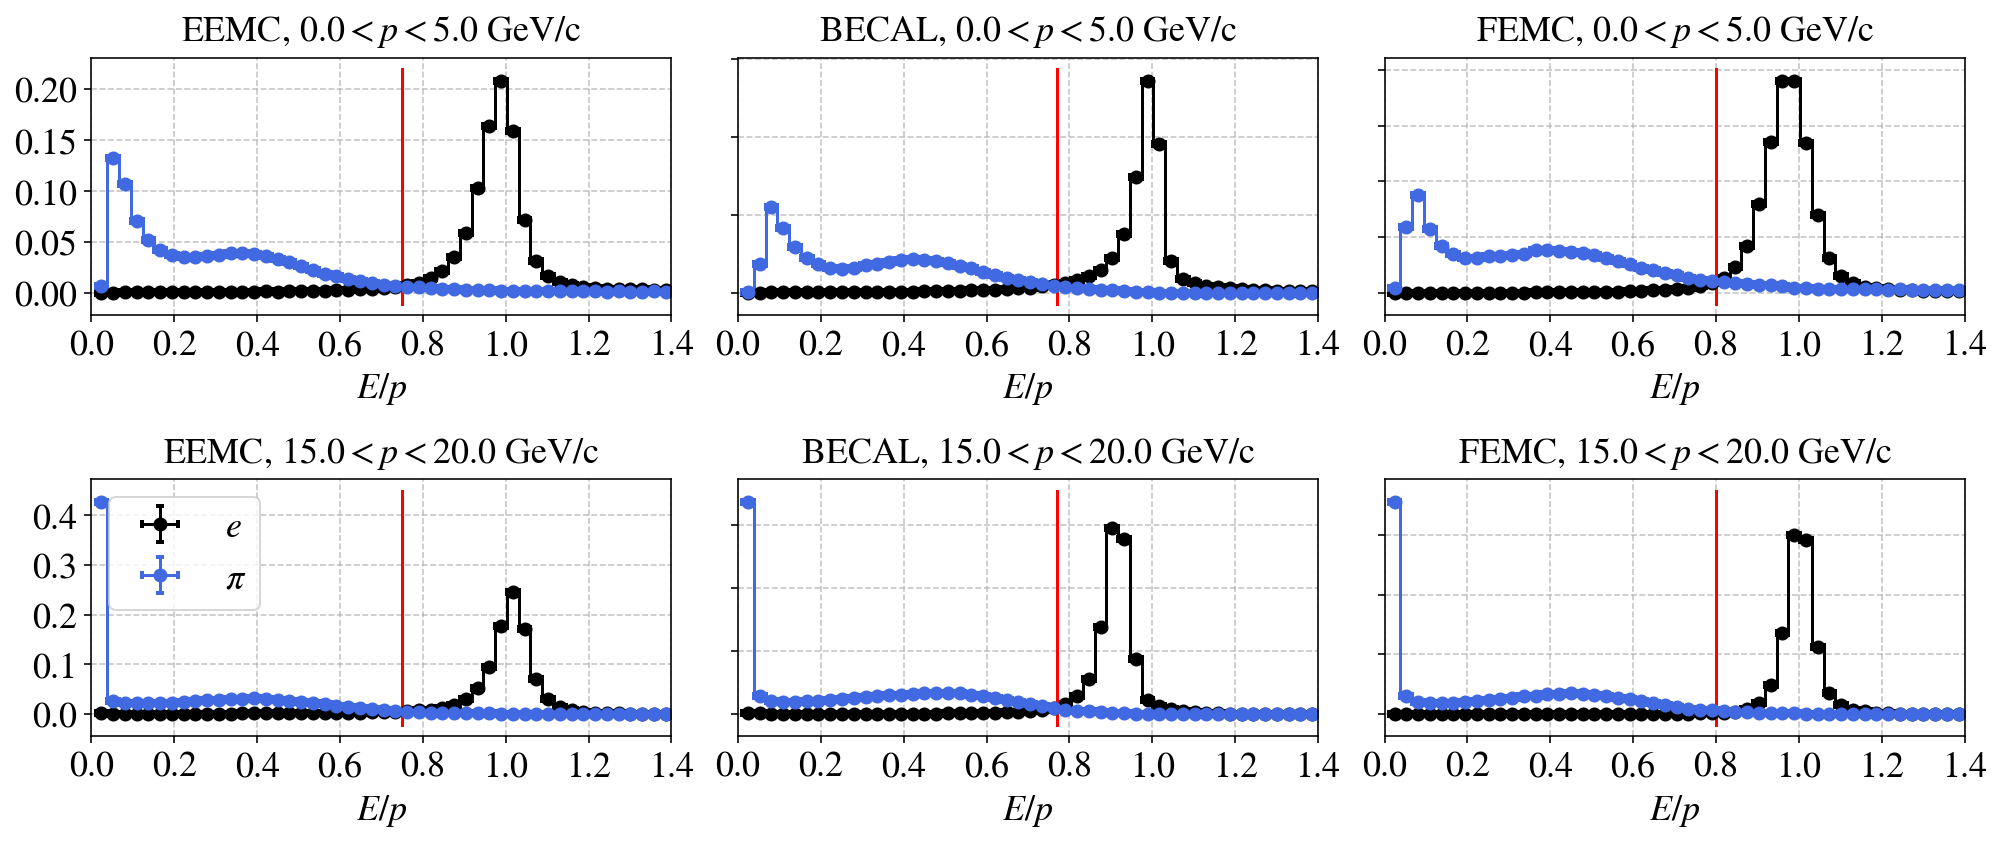

In [118]:
fig  = plt.figure(figsize=(14,6))
bins = np.linspace(0.01,1.4,50)
# ylim = (0,0.155)

for Pmin,Pmax,Pidx in zip([0,15],[5,20],[1,2]):
    for (region,i,region_label,
         region_EMCAL,EMCAL_min_cut) in zip(regions,range(3),region_labels,region_EMCALs,EMCAL_min_cuts):

        ax = fig.add_subplot(2,3, 3*(Pidx-1) + i + 1 )
        df_el, df_pi = el_regions[region], pi_regions[region]
        
        df_el = df_el[(Pmin < df_el['p'])  & (df_el['p'] < Pmax)]
        df_pi = df_pi[(Pmin < df_pi['p'])  & (df_pi['p'] < Pmax)]

        plot_step_hist( df_el[region_EMCAL+' E/p'], bins=bins, label="$e$",   
                       color=e_color,  density=True)
        plot_step_hist( df_pi[region_EMCAL+' E/p'], bins=bins, label="$\pi$", 
                       color=pi_color, density=True)    

        # plot cut
        ylim = ax.get_ylim();
        ax.plot([EMCAL_min_cut,EMCAL_min_cut],ylim,'-r')
        # ax.fill_between([EMCAL_min_cut,np.max(bins)],[0,0],[np.max(ylim),np.max(ylim)],color='red',alpha=0.1)
        # ax.text(EMCAL_min_cut-0.4,0.8*np.max(ylim),'$E/p > %.2f$'%EMCAL_min_cut,color='r',fontsize=18)


        set_axes(ax,'$E/p$','',
                 title=region_EMCAL+', $%.1f<p<%.1f$ GeV/c'%(Pmin,Pmax),
                 remove_ticks_y=True if i>0 else False,
                 do_add_legend=True if i==0 and Pidx==2 else False,do_add_grid=True,fontsize=18,
                 # ylim=ylim, 
                 xlim=(0,np.max(bins)))

plt.tight_layout()

### Hadronic calorimetry response in the different regions

In [30]:
# # problem with FHCAL - filled with zeros
# region='forward'
# df_el = el_regions[region+' EMCAL cut']
# print(np.array(EClusterTot_e['FHCAL']))
# c = ROOT.TCanvas("myCanvasName","The Canvas Title",600,400)
# e_ttree.Draw("E_clusters_matched[0]")
# c.Draw()

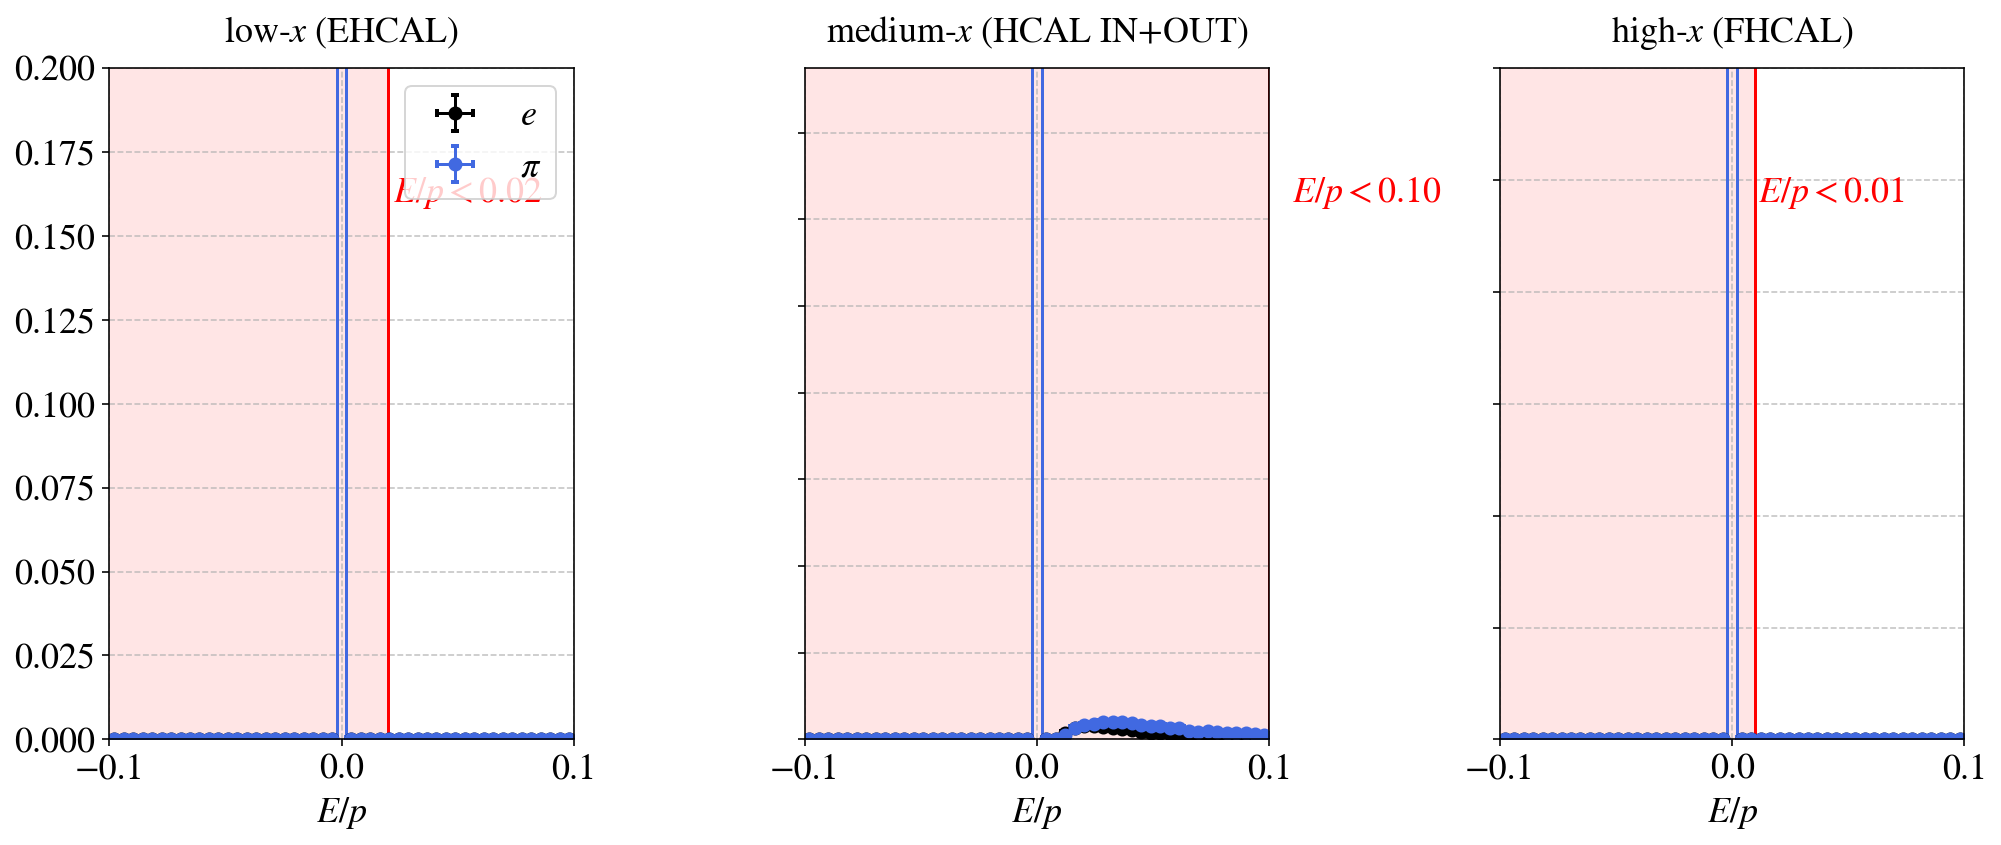

In [31]:
fig  = plt.figure(figsize=(14,6))
#region_bins = [np.linspace(0.0001,0.08,50),np.linspace(0.0001,0.25,50),np.linspace(-0.1,0.1,50)]
region_bins = [np.linspace(-0.1,0.1,50),np.linspace(-0.1,0.1,50),np.linspace(-0.1,0.1,50)]
region_ylim = [(0,0.2),(0,0.155),(0,0.3)]
# region_xticks=[(0.01,0.03,0.05,0.07),(0.05,0.1,0.15,0.2),(-0.1,0,0.1)]
region_xticks=[(-0.1,0.0,0.1,),(-0.1,0,0.1),(-0.1,0,0.1)]

for (region,i,region_label,
     region_HCAL,HCAL_max_cut,bins,ylim,xticks) in zip(regions,range(3),region_labels,
                                           region_HCALs,HCAL_max_cuts,region_bins,region_ylim,region_xticks):
    
    ax = fig.add_subplot(1,3,i+1)
    df_el, df_pi = el_regions[region+' EMCAL cut'], pi_regions[region+' EMCAL cut']
    
    plot_step_hist( df_el[region_HCAL+' E/p'], bins=bins, label="$e$",   
                   color=e_color,  density=True)
    plot_step_hist( df_pi[region_HCAL+' E/p'], bins=bins, label="$\pi$", 
                   color=pi_color, density=True)    
    
    # plot cut
    ax.plot([HCAL_max_cut,HCAL_max_cut],ylim,'-r')
    ax.fill_between([np.min(bins),HCAL_max_cut],[0,0],[np.max(ylim),np.max(ylim)],color='red',alpha=0.1)
    ax.text(HCAL_max_cut*1.1,0.8*np.max(ylim),'$E/p < %.2f$'%HCAL_max_cut,color='r',fontsize=18)

    
    set_axes(ax,'$E/p$','',title=region_label+' ('+region_HCAL+')',remove_ticks_y=True if i>0 else False,
             do_add_legend=True if i==0 else False,do_add_grid=True,fontsize=18,
             xticks=xticks,
             ylim=ylim, xlim=(np.min(bins),np.max(bins)))
    
plt.tight_layout()

## Now repeat all in bins of electron momentum

In [32]:
Pbins = np.linspace(0,20,21) # 1 GeV/c bins
Pmins,Pmaxs = Pbins[:-1],Pbins[1:]
Pcenters = (Pmaxs+Pmins)/2
Pwidths  = (Pmaxs-Pmins)/2
print('p:',Pcenters)
print('dp:',Pwidths);
print('Pmins:',Pmins);
print('Pmaxs:',Pmaxs);

p: [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5]
dp: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5]
Pmins: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]
Pmaxs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


In [33]:
el_eff,el_eff_err,pi_eff,pi_eff_err = dict(),dict(),dict(),dict()
for region in regions:
    el_eff[region],el_eff_err[region],pi_eff[region],pi_eff_err[region] = [],[],[],[]  

for Pmin,Pmax in zip(Pmins,Pmaxs):
    for (region,
         region_EMCAL,EMCAL_min_cut,
         region_HCAL,HCAL_max_cut) in zip(regions,
                                          region_EMCALs, EMCAL_min_cuts,
                                          region_HCALs , HCAL_max_cuts):
        
        df_el = el_regions[region][(Pmin < el_regions[region]['p'])&(el_regions[region]['p']<Pmax)]
        df_pi = pi_regions[region][(Pmin < pi_regions[region]['p'])&(pi_regions[region]['p']<Pmax)]
        
        df_el_EMCAL = df_el[df_el[region_EMCAL+' E/p'] > EMCAL_min_cut]        
        df_pi_EMCAL = df_pi[df_pi[region_EMCAL+' E/p'] > EMCAL_min_cut]
        
        df_el_HCAL = df_el_EMCAL[HCAL_max_cut > df_el_EMCAL[region_HCAL+' E/p']]
        df_pi_HCAL = df_pi_EMCAL[HCAL_max_cut > df_pi_EMCAL[region_HCAL+' E/p']]

        [f_e_in_cut, f_pi_in_cut, 
         f_e_in_cut_err, f_pi_in_cut_err] = compute_fraction_in_cut( df_el, df_el_HCAL, df_pi, df_pi_HCAL)
        
        #print(f_e_in_cut, f_pi_in_cut,  f_e_in_cut_err, f_pi_in_cut_err)
        
        el_eff[region]      .append(f_e_in_cut)
        el_eff_err[region]  .append(f_e_in_cut_err)
        pi_eff[region]      .append(f_pi_in_cut)
        pi_eff_err[region]  .append(f_pi_in_cut_err)
        
for region in regions:
    el_eff[region],el_eff_err[region],pi_eff[region],pi_eff_err[region] = np.array(el_eff[region]),np.array(el_eff_err[region]),np.array(pi_eff[region]),np.array(pi_eff_err[region]) 

print('done computing electron and pion survival efficiency in each momentum bin.')

done computing electron and pion survival efficiency in each momentum bin.


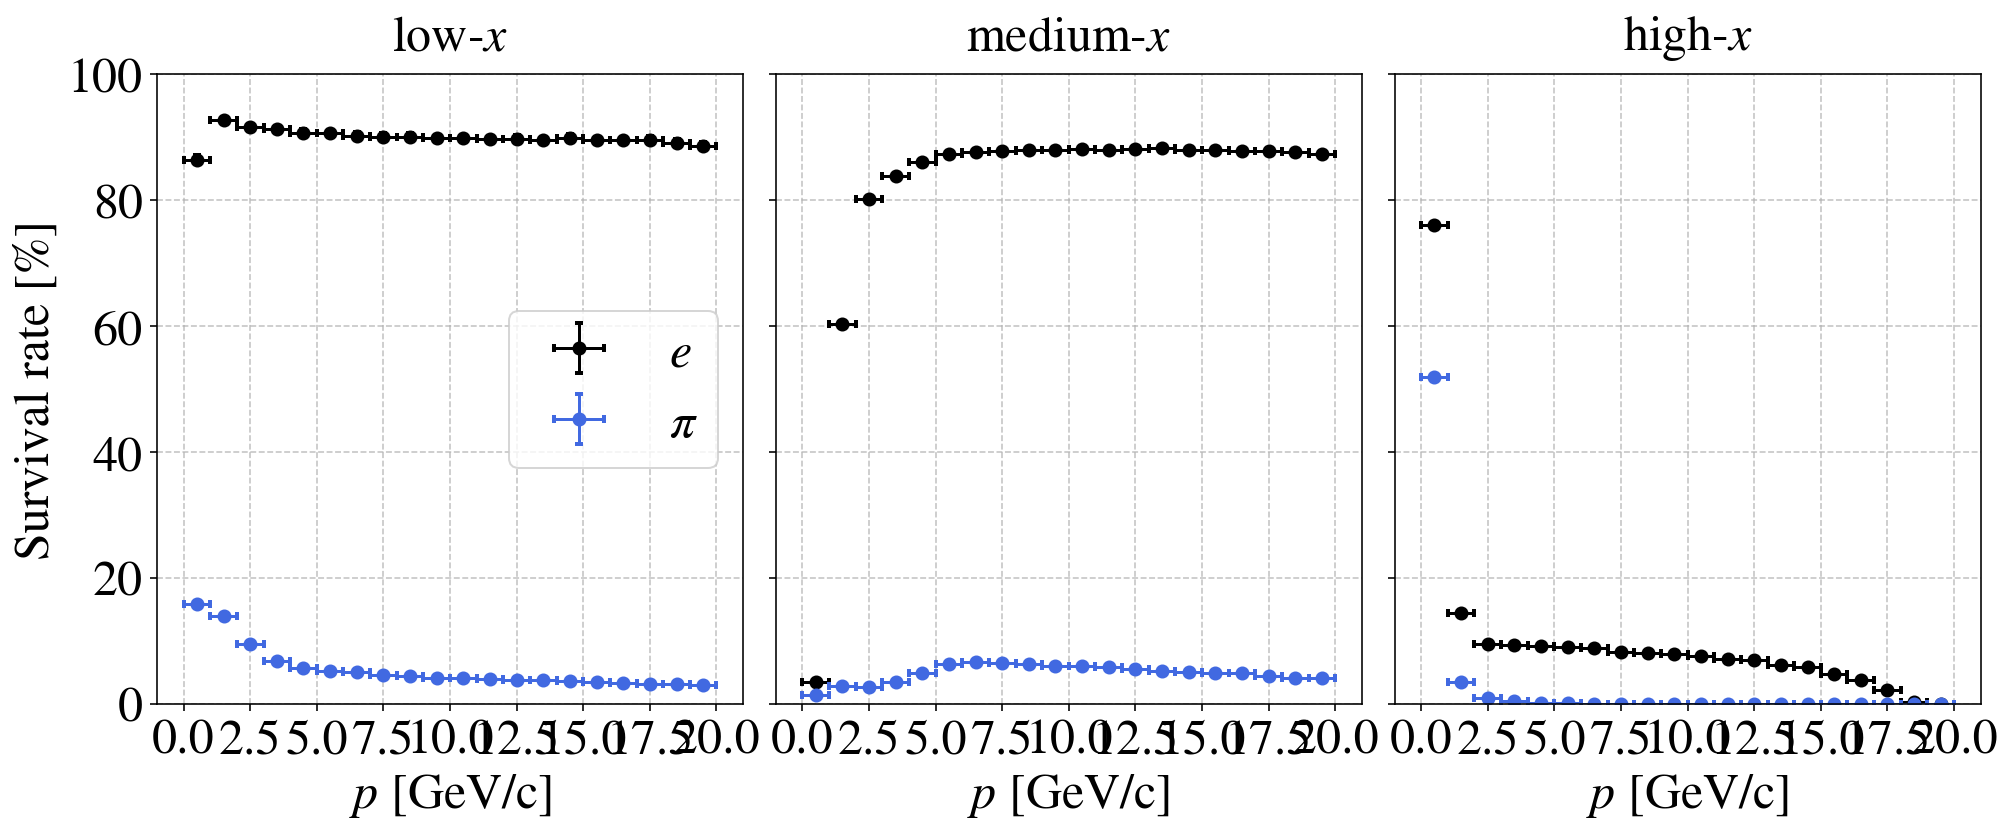

In [34]:
ylim = (0,100)
fig = plt.figure(figsize=(14,6))
for region,i,region_label in zip(regions,range(3),region_labels):
    ax=fig.add_subplot(1,3,i+1)
    ax.errorbar(x=Pcenters, xerr=Pwidths,                    
                y=100.*el_eff[region], yerr=100.*el_eff_err[region], 
                color=e_color,marker='o',linestyle='None',
                capthick=2, capsize=2 , label='$e$')

    ax.errorbar(x=Pcenters, xerr=Pwidths,                    
                y=100.*pi_eff[region], yerr=100.*pi_eff_err[region], 
                color=pi_color,marker='o',linestyle='None',
                capthick=2, capsize=2 , label='$\pi$')
    
    set_axes(ax,'$p$ [GeV/c]','Survival rate [%]' if i==0 else '',remove_ticks_y=True if i>0 else False,
             title=region_label,
             do_add_grid=True,do_add_legend=True if i==0 else False, ylim=ylim);
    
plt.tight_layout()

## Repeat all in bins of electron momentum and finer bins of $\eta$

In [60]:
eta_lim_EEMC_dw = eta_limits['backward min']
eta_lim_EEMC_up = eta_limits['backward max']

eta_lim_BECAL_dw = eta_limits['center min']
eta_lim_BECAL_up = eta_limits['center max']

eta_lim_FEMC_dw = eta_limits['forward min']
eta_lim_FEMC_up = eta_limits['forward max']

eta_mins    = np.concatenate([np.linspace(eta_lim_EEMC_dw,eta_lim_EEMC_up-(eta_lim_EEMC_up-(eta_lim_EEMC_dw))/4,4) , 
                              np.linspace(eta_lim_BECAL_dw,eta_lim_BECAL_up-(eta_lim_BECAL_up-(eta_lim_BECAL_dw))/4,4) , 
                              np.linspace(eta_lim_FEMC_dw,eta_lim_FEMC_up-(eta_lim_FEMC_up-(eta_lim_FEMC_dw))/4,4) ])
eta_maxs    = np.concatenate([np.linspace(eta_lim_EEMC_dw+(eta_lim_EEMC_up-(eta_lim_EEMC_dw))/4,eta_lim_EEMC_up,4) , 
                              np.linspace(eta_lim_BECAL_dw+(eta_lim_BECAL_up-(eta_lim_BECAL_dw))/4,eta_lim_BECAL_up,4) , 
                              np.linspace(eta_lim_FEMC_dw+(eta_lim_FEMC_up-(eta_lim_FEMC_dw))/4,eta_lim_FEMC_up,4) ])
eta_centers = (eta_maxs+eta_mins)/2
eta_widths  = (eta_maxs-eta_mins)/2
eta_mins,eta_maxs

(array([-3.8    , -3.2875 , -2.775  , -2.2625 , -1.75   , -0.99625,
        -0.2425 ,  0.51125,  1.75   ,  2.2625 ,  2.775  ,  3.2875 ]),
 array([-3.2875 , -2.775  , -2.2625 , -1.75   , -0.99625, -0.2425 ,
         0.51125,  1.265  ,  2.2625 ,  2.775  ,  3.2875 ,  3.8    ]))

In [78]:
el_eff,el_eff_err,pi_eff,pi_eff_err = dict(),dict(),dict(),dict()
pi_rej,pi_rej_err = dict(),dict()
for eta_min,eta_max in zip(eta_mins,eta_maxs):
    region = get_region_from_eta_lims(eta_min,eta_max)
    eta_label =  '%.2f-%.2f'%(eta_min, eta_max)
    el_eff[eta_label],el_eff_err[eta_label],pi_eff[eta_label],pi_eff_err[eta_label] = [],[],[],[]  
    pi_rej[eta_label],pi_rej_err[eta_label] = [],[]
    
    
for Pmin,Pmax in zip(Pmins,Pmaxs):
    
    for eta_min,eta_max in zip(eta_mins,eta_maxs):
        region = get_region_from_eta_lims(eta_min,eta_max)
        region_EMCAL,EMCAL_min_cut,region_HCAL,HCAL_max_cut = get_regionCuts_from_region( region )
        eta_label =  '%.2f-%.2f'%(eta_min, eta_max)

        el_in_eta_bin = el_regions[region][(eta_min < el_regions[region]['eta'])
                                           &
                                           (el_regions[region]['eta']<eta_max)]

        pi_in_eta_bin = pi_regions[region][(eta_min < pi_regions[region]['eta'])
                                           &
                                           (pi_regions[region]['eta']<eta_max)]

    

        
        df_el = el_in_eta_bin[(Pmin < el_in_eta_bin['p'])&(el_in_eta_bin['p']<Pmax)]
        df_pi = pi_in_eta_bin[(Pmin < pi_in_eta_bin['p'])&(pi_in_eta_bin['p']<Pmax)]
        
        df_el_EMCAL = df_el[df_el[region_EMCAL+' E/p'] > EMCAL_min_cut]        
        df_pi_EMCAL = df_pi[df_pi[region_EMCAL+' E/p'] > EMCAL_min_cut]
        
        df_el_HCAL = df_el_EMCAL[HCAL_max_cut > df_el_EMCAL[region_HCAL+' E/p']]
        df_pi_HCAL = df_pi_EMCAL[HCAL_max_cut > df_pi_EMCAL[region_HCAL+' E/p']]

        [f_e_in_cut, f_pi_in_cut, 
         f_e_in_cut_err, f_pi_in_cut_err] = compute_fraction_in_cut( df_el, df_el_HCAL, df_pi, df_pi_HCAL)
        
        el_eff[eta_label]      .append(f_e_in_cut)
        el_eff_err[eta_label]  .append(f_e_in_cut_err)
        pi_eff[eta_label]      .append(f_pi_in_cut)
        pi_eff_err[eta_label]  .append(f_pi_in_cut_err)
        pi_rej[eta_label]      .append(1./f_pi_in_cut)
        pi_rej_err[eta_label]  .append(f_pi_in_cut_err)
        
print('done computing electron and pion survival efficiency in each momentum and pseodu rapidity bin.')

done computing electron and pion survival efficiency in each momentum and pseodu rapidity bin.


In [63]:
for eta_min,eta_max in zip(eta_mins,eta_maxs):
    eta_label =  '%.2f-%.2f'%(eta_min, eta_max)
    el_eff[eta_label]     = np.array(el_eff[eta_label])
    el_eff_err[eta_label] = np.array(el_eff_err[eta_label])
    pi_eff[eta_label]     = np.array(pi_eff[eta_label])
    pi_eff_err[eta_label] = np.array(pi_eff_err[eta_label])
    # print(eta_label,region,el_eff[eta_label])

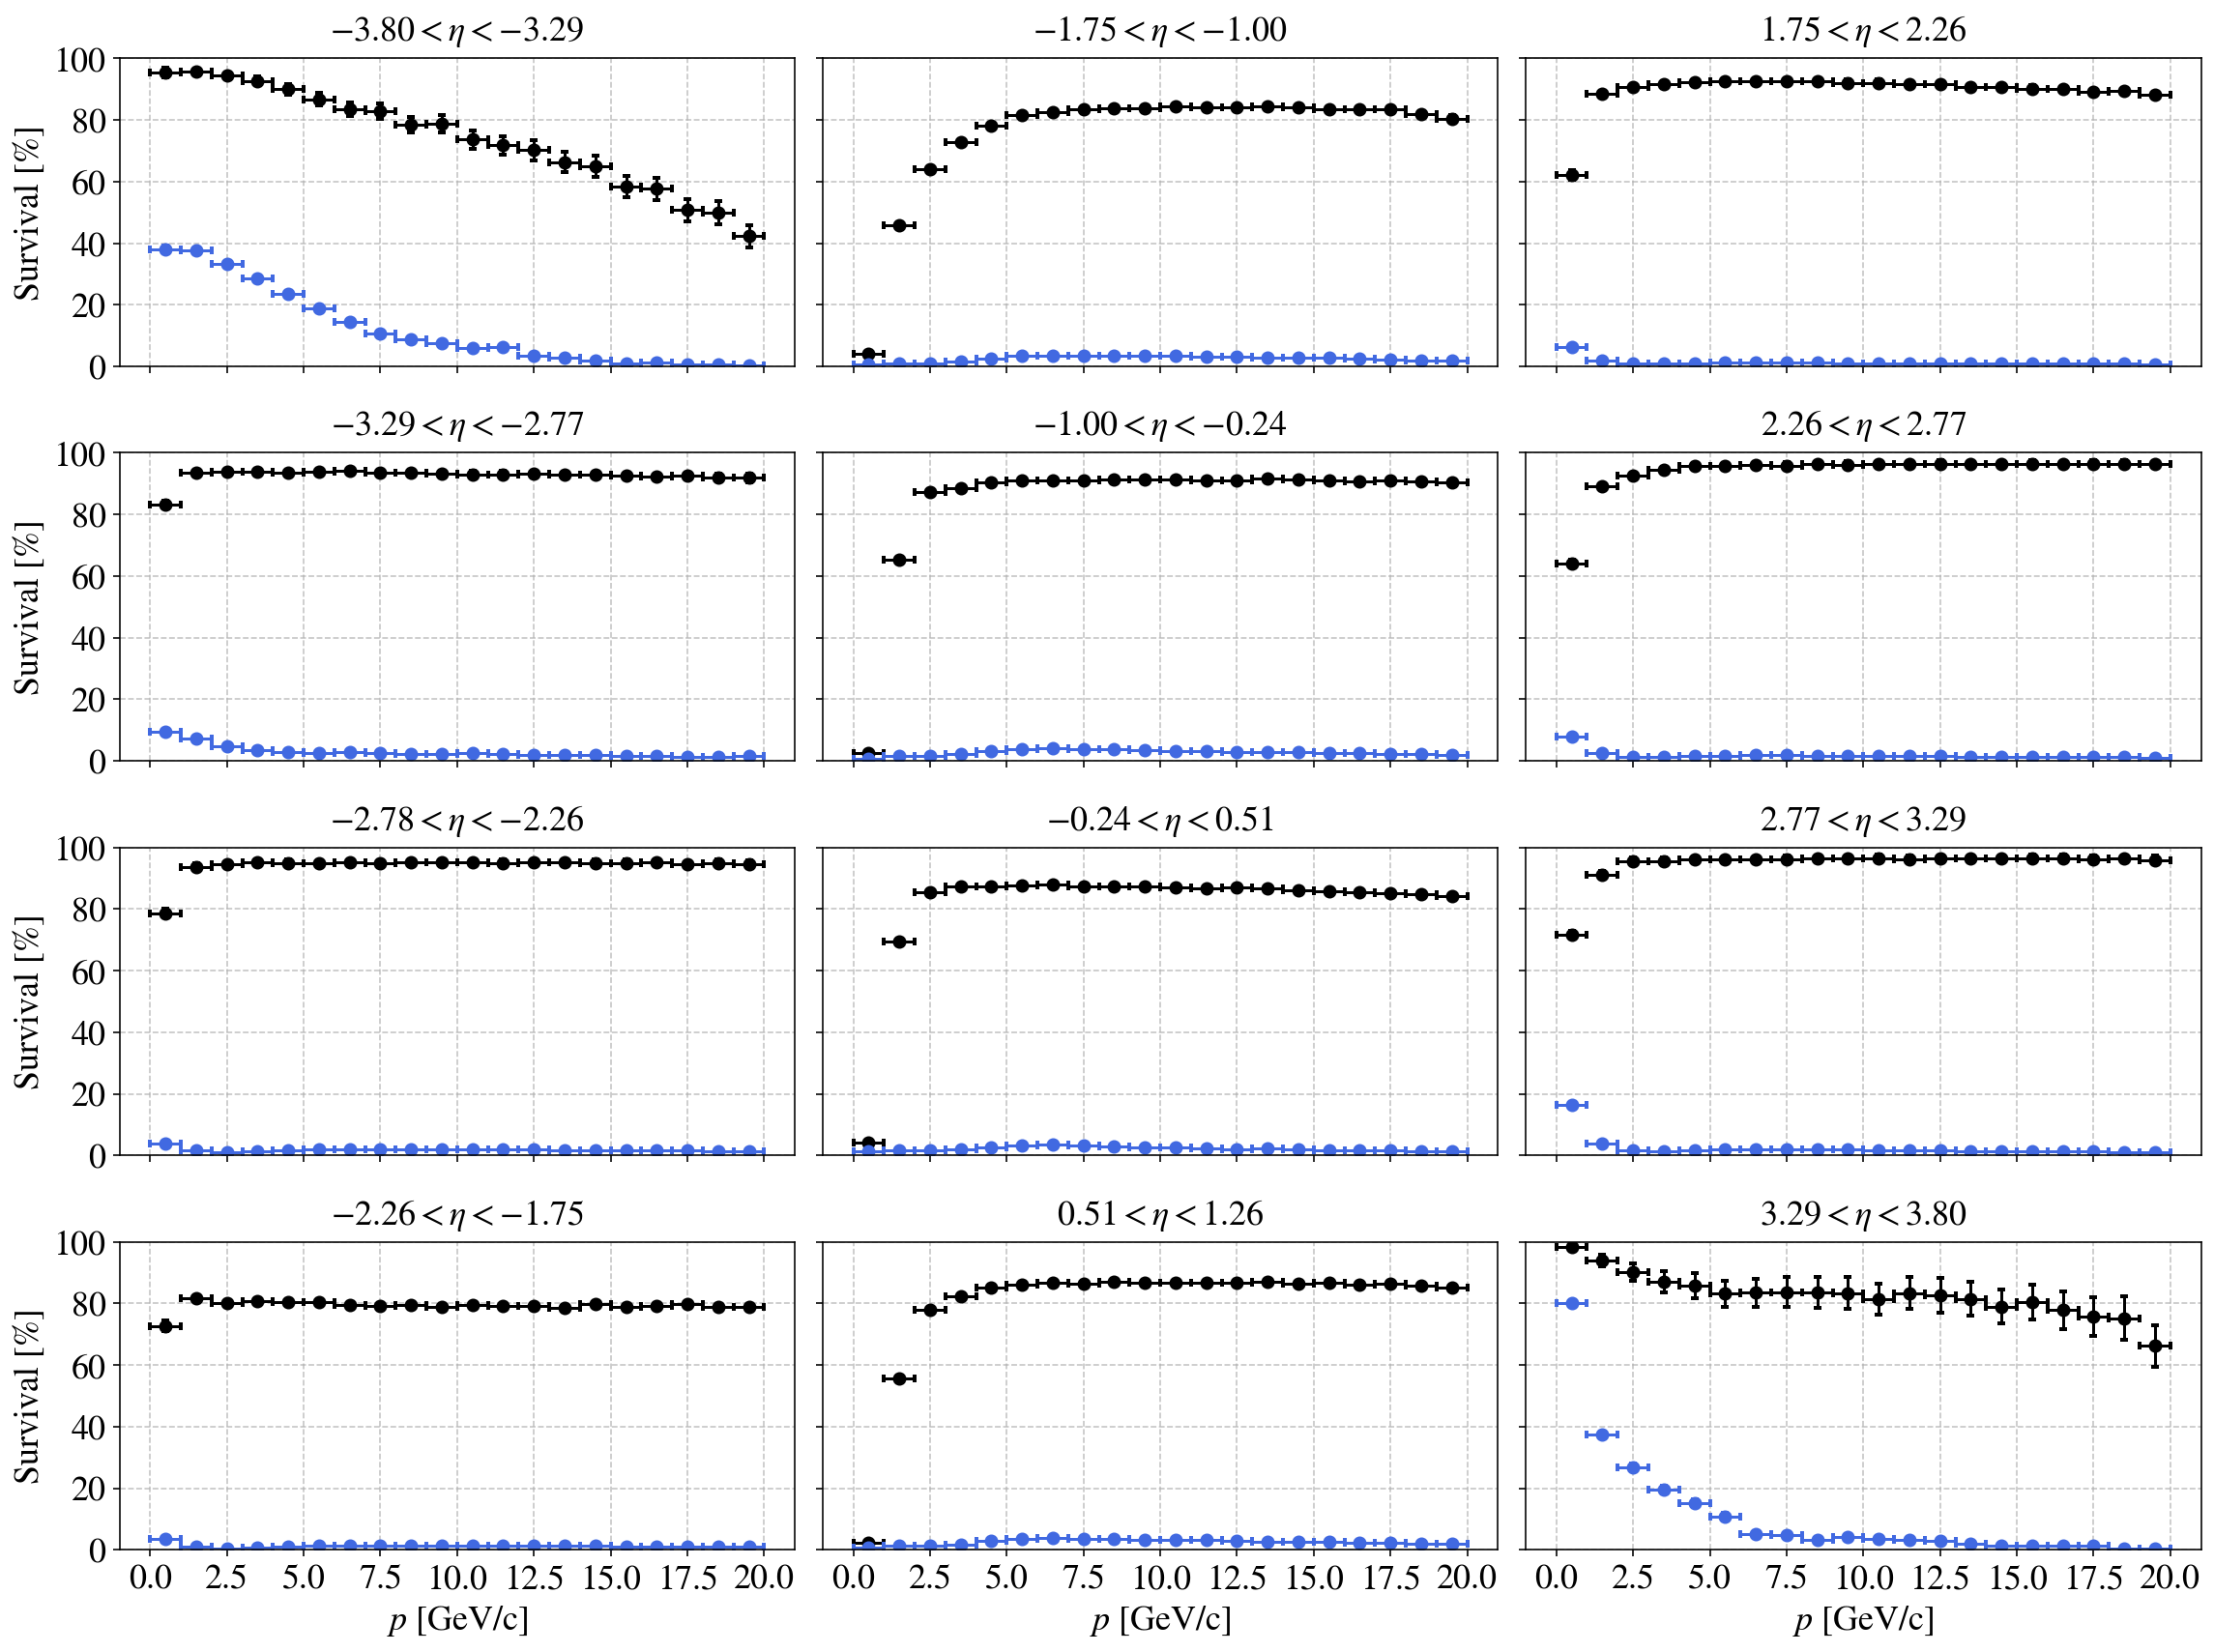

In [64]:
ylim = (0,100)
fig = plt.figure(figsize=(16,12))

for eta_min,eta_max,eta_indx in zip(eta_mins,eta_maxs,range(len(eta_mins))):
    region = get_region_from_eta_lims(eta_min,eta_max)
    region_label = get_region_label_from_region( region )
    eta_label =  '%.2f-%.2f'%(eta_min, eta_max)
    
    
    if (region=='backward'):  i=1
    elif (region=='center'):  i=2
    elif (region=='forward'): i=3
    j = eta_indx%4
    ax=fig.add_subplot(4,3,i + j*3)
    ax.errorbar(x=Pcenters, xerr=Pwidths,                    
                y=100.*el_eff[eta_label], yerr=100.*el_eff_err[eta_label], 
                color=e_color,marker='o',linestyle='None',
                capthick=2, capsize=2 , label='$e$')

    ax.errorbar(x=Pcenters, xerr=Pwidths,                    
                y=100.*pi_eff[eta_label], yerr=100.*pi_eff_err[eta_label], 
                color=pi_color,marker='o',linestyle='None',
                capthick=2, capsize=2 , label='$\pi$')
    
    set_axes(ax,'' if j<3 else '$p$ [GeV/c]',
             'Survival [%]' if i==1 else '',
             remove_ticks_y=True if i>1 else False,
             remove_ticks_x=True if j<3 else False,
             title='$%.2f < \eta < %.2f$'%(eta_min,eta_max),
             do_add_grid=True,do_add_legend=False if i==1 else False, ylim=ylim,fontsize=18);
    
plt.tight_layout()

In [69]:
pi_rej

{'-3.80--3.29': array([0.61859378, 0.62300337, 0.66622986, 0.71463775, 0.76548043,
        0.81023185, 0.85509182, 0.89139515, 0.91227229, 0.92316785,
        0.94072524, 0.93555901, 0.96471601, 0.96988577, 0.97972973,
        0.98974359, 0.98676471, 0.99375   , 0.99233716, 0.99591002]),
 '-3.29--2.77': array([0.90617284, 0.92706179, 0.95313072, 0.96589388, 0.97018805,
        0.97325725, 0.97161705, 0.97535491, 0.9757586 , 0.97701482,
        0.9755472 , 0.97726619, 0.97880292, 0.97984724, 0.98099791,
        0.98281828, 0.98396238, 0.98597009, 0.98528289, 0.9850216 ]),
 '-2.78--2.26': array([0.9622595 , 0.98369318, 0.99075327, 0.98788118, 0.98390921,
        0.98100028, 0.97968803, 0.97897453, 0.97932961, 0.98067287,
        0.97989142, 0.98156889, 0.98155394, 0.98173845, 0.98224294,
        0.98253374, 0.98418278, 0.98324968, 0.98558682, 0.98494318]),
 '-2.26--1.75': array([0.9646494 , 0.98956542, 0.99447482, 0.99244704, 0.98929192,
        0.98553201, 0.98495475, 0.9857345 , 0.9874

# Produce a plot of pion rejection, similar to YR figure 11.48 (right)


In [79]:
for eta_min,eta_max in zip(eta_mins,eta_maxs):
    eta_label =  '%.2f-%.2f'%(eta_min, eta_max)
    pi_rej[eta_label]     = np.array(pi_rej[eta_label])
    pi_rej_err[eta_label] = np.array(pi_rej_err[eta_label])
    # print(eta_label,region,el_eff[eta_label])

In [88]:
# eta_centers
eta_widths

array([0.25625 , 0.25625 , 0.25625 , 0.25625 , 0.376875, 0.376875,
       0.376875, 0.376875, 0.25625 , 0.25625 , 0.25625 , 0.25625 ])

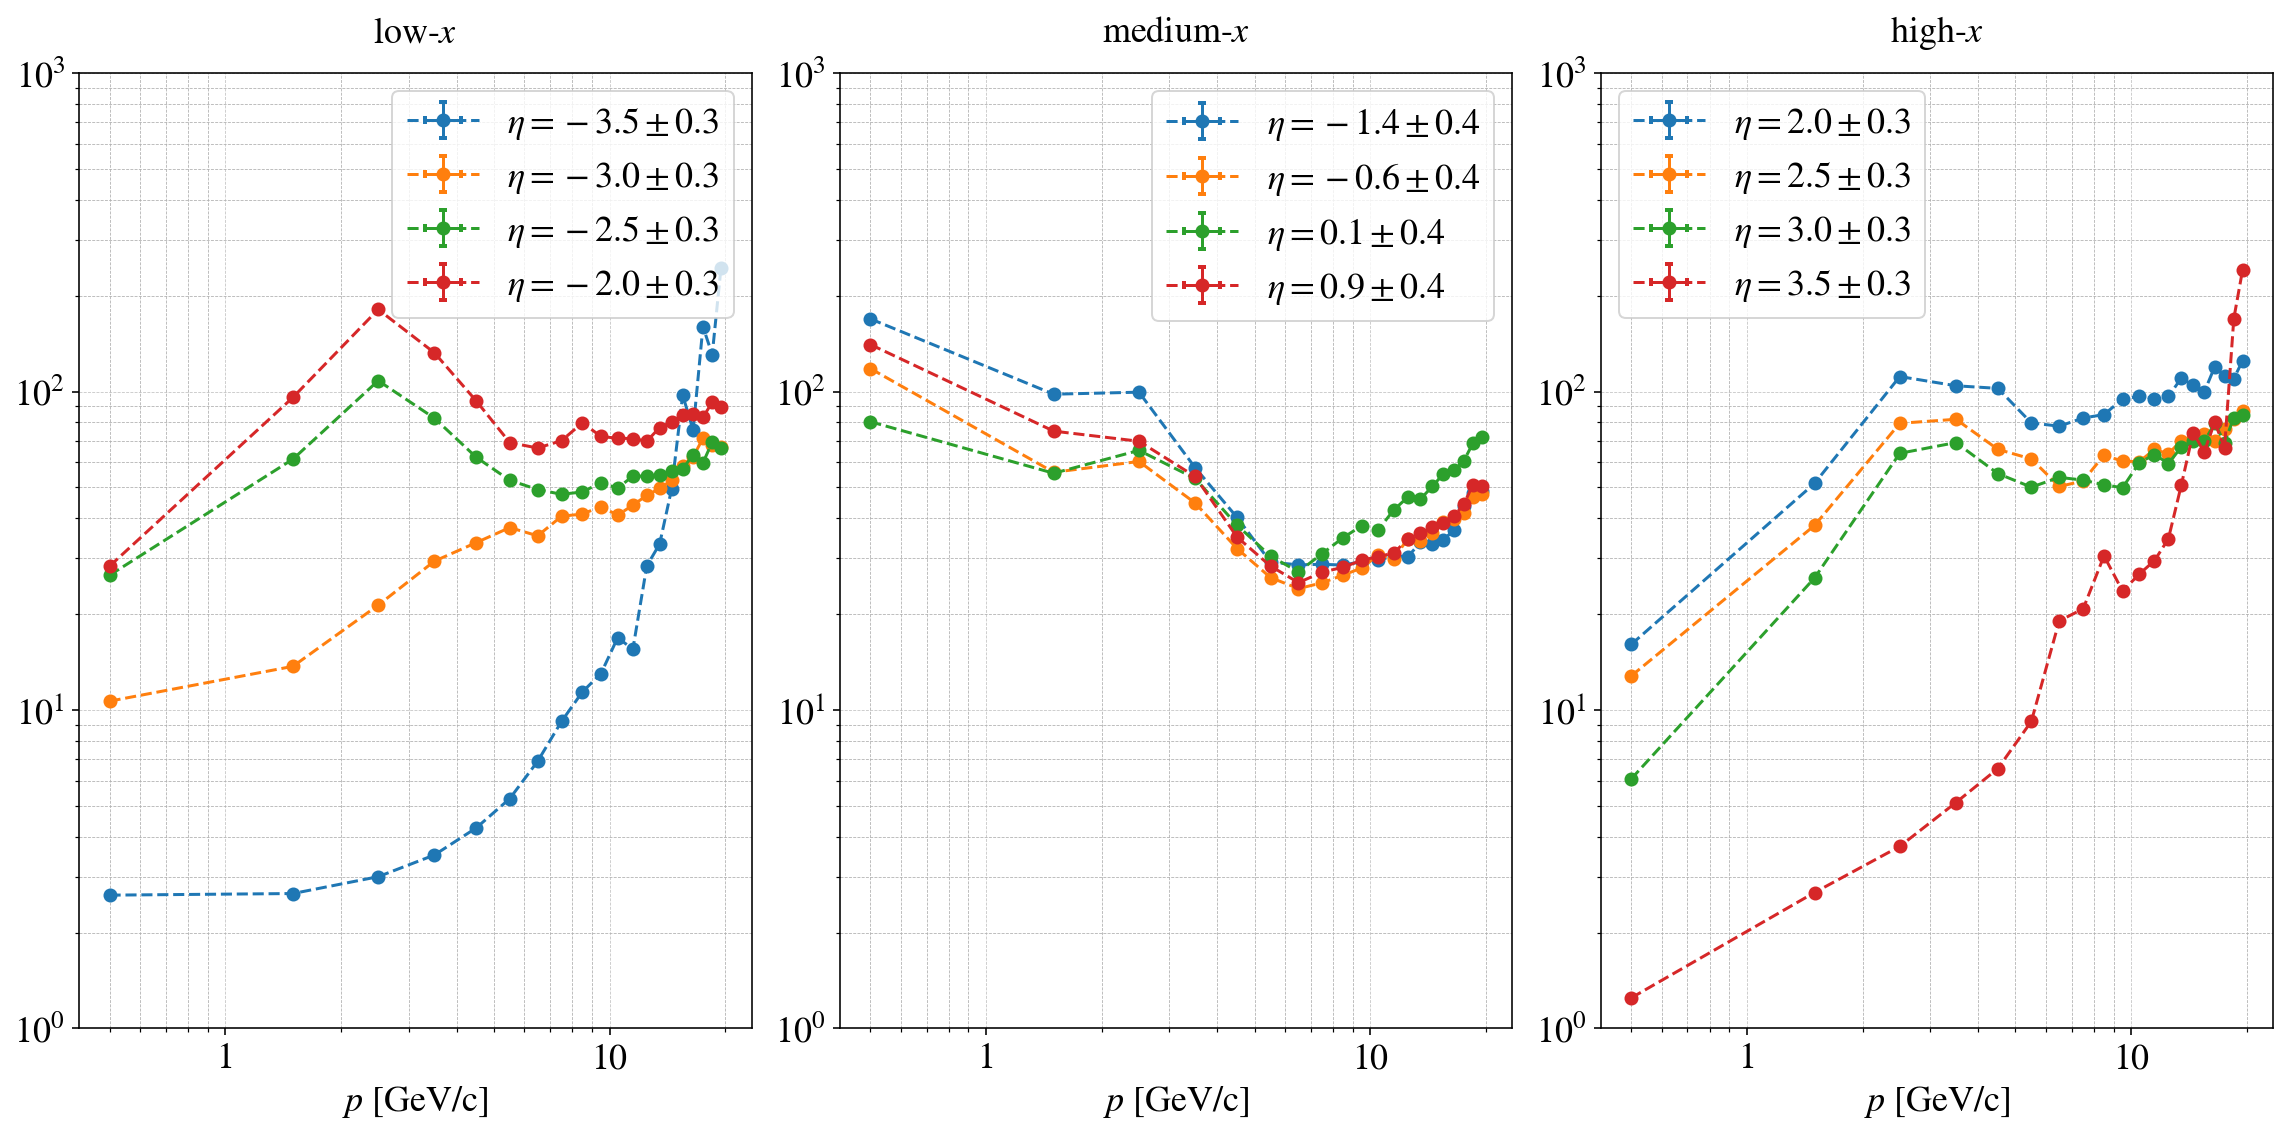

In [110]:
ylim = (1e0,1e3)
fig = plt.figure(figsize=(16,8))
axes = dict()

for i in range(1,4):
    axes[i] = fig.add_subplot(1,3,i)

for eta_min,eta_max,eta_center,eta_width,eta_indx in zip(eta_mins,eta_maxs,eta_centers,eta_widths,range(len(eta_mins))):
    region = get_region_from_eta_lims(eta_min,eta_max)
    region_label = get_region_label_from_region( region )
    eta_label =  '%.2f-%.2f'%(eta_min, eta_max)
    if (region=='backward'):  i=1
    elif (region=='center'):  i=2
    elif (region=='forward'): i=3
    j = eta_indx%4
    axes[i].errorbar(x=Pcenters, xerr=0,                    
                y=pi_rej[eta_label], yerr=pi_rej_err[eta_label], 
                marker='o',linestyle='--',
                capthick=2, capsize=2 , 
                label='$\eta = %.1f\pm%.1f$'%(eta_center,eta_width),)
    
for i in range(1,4):
    set_axes(axes[i],
             '$p$ [GeV/c]',
             '',
             remove_ticks_y=True if i>1 else False,
             remove_ticks_x=False,
             title=region_labels[i-1],
             do_add_grid=True,
             do_add_legend=True, 
             ylim=ylim,
             fontsize=18);
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_xticks([1,10])
    axes[i].set_xticklabels(['1','10'])
    axes[i].grid(which='both',linestyle='--',linewidth=0.4)    
plt.tight_layout()